In [1]:

import argparse
import csv
import sys

import itertools
import MDAnalysis as mda

import matplotlib
matplotlib.use('Agg')  # noqa
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import numpy.linalg
from MDAnalysis.analysis.dihedrals import Ramachandran
import MDAnalysis as mda
from MDAnalysis.lib.distances import calc_dihedrals


import numpy.linalg
import numpy as np

import seaborn as sns
from collections import namedtuple



In [7]:
params = {'ramachandran1': {'phi': {'atom1': {'segid': 'CARA', 'resid': 1, 'name': 'O5'}, 'atom2': {'segid': 'CARA', 'resid': 1, 'name': 'C1'}, 'atom3': {'segid': 'PROF', 'resid': 4, 'name': 'OG1'}, 'atom4': {'segid': 'PROF', 'resid': 4, 'name': 'CB'}}, 'psi': {'atom1': {'segid': 'CARA', 'resid': 1, 'name': 'C1'}, 'atom2': {'segid': 'PROF', 'resid': 4, 'name': 'OG1'}, 'atom3': {'segid': 'PROF', 'resid': 4, 'name': 'CB'}, 'atom4': {'segid': 'PROF', 'resid': 4, 'name': 'CA'}}}}

#with open("params.yml") as file:
#    params = yaml.load(file, Loader=yaml.FullLoader)

    

In [8]:
Dihedral = namedtuple(
    'Dihedral', ['atom1', 'atom2', 'atom3', 'atom4'])

for k,v in params.items():
   for a in ['phi','psi']:
       assert (a in v), "Key %s is missing in inputs: %s " % (a, k)
       atoms=[]
       for b in ['atom1','atom2','atom3','atom4']:
          assert (b in v[a]), "Key %s is missing in inputs: %s %s" % (b, k, a)
          for c in ['segid','resid','name']:
              assert (c in v[a][b]), "Key %s is missing in inputs: %s %s %s " % (c, k, a, b)
          atoms.append("(segid %s and resid %s and name %s)" % (v[a][b]['segid'], v[a][b]['resid'], v[a][b]['name']))
       print(atoms)
       if a=='phi':
           dihe_phi = Dihedral(atoms[0],atoms[1], atoms[2], atoms[3])
       if a=='psi':
           dihe_psi = Dihedral(atoms[0],atoms[1], atoms[2], atoms[3])

# order of dihedral atom is the crystallographic definition
# (see glycanstructure.org)

assert(dihe_phi), "phi dihedral doesn't exist"
assert(dihe_psi), "psi dihedral doesn't exist"



['(segid CARA and resid 1 and name O5)', '(segid CARA and resid 1 and name C1)', '(segid PROF and resid 4 and name OG1)', '(segid PROF and resid 4 and name CB)']
['(segid CARA and resid 1 and name C1)', '(segid PROF and resid 4 and name OG1)', '(segid PROF and resid 4 and name CB)', '(segid PROF and resid 4 and name CA)']


In [9]:
def calc_torsion(dihedral):
    """atom 1 -4 are valid atom selections. torsion in degrees is returned"""
    A = u.select_atoms(dihedral.atom1).positions
    B = u.select_atoms(dihedral.atom2).positions
    C = u.select_atoms(dihedral.atom3).positions
    D = u.select_atoms(dihedral.atom4).positions

    dihe = calc_dihedrals(A, B, C, D)
    return np.rad2deg(dihe)



In [10]:

u = mda.Universe( "step3_charmm2omm.pdb","step5_1.dcd")



[[0 array([69.33258045])]
 [1 array([65.18465961])]
 [2 array([64.97783602])]
 ...
 [997 array([60.2946603])]
 [998 array([79.03514177])]
 [999 array([72.8906985])]] [[0 array([95.6632604])]
 [1 array([100.47785415])]
 [2 array([111.5504084])]
 ...
 [997 array([126.03406601])]
 [998 array([126.80694053])]
 [999 array([123.9063749])]]


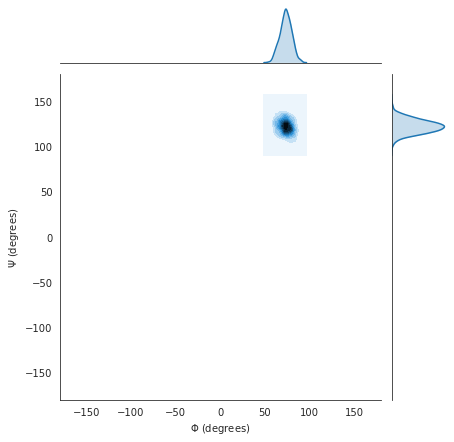

In [11]:
phi_trajdata = np.array(
    [(u.trajectory.frame, calc_torsion(dihe_phi)) for ts in u.trajectory])
psi_trajdata = np.array(
    [(u.trajectory.frame, calc_torsion(dihe_psi)) for ts in u.trajectory])

print(phi_trajdata, psi_trajdata)

phi_frame, phi_series = phi_trajdata.T
psi_frame, psi_series = psi_trajdata.T

phi_series = np.concatenate(phi_series, axis=0)
psi_series = np.concatenate(psi_series, axis=0)

#zip(phi_frame, phi_series, psi_series)

#with open(args.output, 'w') as f:
#    writer = csv.writer(f, delimiter='\t')
#    writer.writerows(zip(phi_frame, phi_series, psi_series))

with sns.axes_style("white"):
    h = sns.jointplot(x=phi_series, y=psi_series, kind="kde", legend=True)
    h.set_axis_labels(r'$\Phi$ (degrees)', r'$\Psi$ (degrees)')
    h.ax_joint.set_xlim(-180, 180)
    h.ax_joint.set_ylim(-180, 180)
    plt.show()
                                                           